## SNP Density

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import math
import seaborn as sns
import scipy.stats
from scipy.optimize import curve_fit

In [3]:
mlma_v5 = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/MLMA/20220822/Trait1.loco.mlma'
df_mlma_pruned_v5 = pd.read_csv(mlma_v5,header=0, index_col=False, sep='\t')
df_mlma_pruned_v5.insert(0, '-log10_P', df_mlma_pruned_v5['p'].apply(lambda x: math.log(x, 10)*(-1)))
df_mlma_pruned_v5

,-log10_P,Unnamed: 0,Chr,SNP,bp,A1,A2,Freq,b,se,p
0,0.736089,0,4,4:2425,2425,C,T,0.032276,-0.068778,0.051724,0.183616
1,1.003770,1,4,4:2484,2484,A,T,0.026167,-0.094689,0.057420,0.099136
2,0.006139,2,4,4:3809,3809,C,T,0.107130,-0.000622,0.035382,0.985963
3,0.132564,3,4,4:6295,6295,G,A,0.113694,0.011698,0.034826,0.736947
4,0.185595,4,4,4:6452,6452,T,G,0.098559,-0.016460,0.036524,0.652236
...,...,...,...,...,...,...,...,...,...,...,...
4186078,0.047795,186382,6,6:60265216,60265216,T,C,0.009938,-0.011867,0.090602,0.895788
4186079,1.002300,186383,6,6:60266992,60266992,C,T,0.013767,-0.146072,0.088667,0.099472
4186080,0.644148,186384,6,6:60267121,60267121,G,A,0.010941,-0.122277,0.101193,0.226909
4186081,0.641858,186385,6,6:60267257,60267257,A,G,0.012035,-0.114874,0.095312,0.228109


In [4]:
#f, ax=plt.subplots(2,1)
df_list=[]
for chr_num in range (1,26):
    pos_start = []
    pos_end = []
    snp_num_dic={}
    df_chr = df_mlma_pruned_v5.loc[df_mlma_pruned_v5['Chr']==chr_num]
    start = df_chr['bp'].min()
    end = df_chr['bp'].max()
    snp_num_list=[]
    for pos in np.arange(0, 80000000, 100000):
        df = df_chr.loc[(df_chr['bp']>pos)&(df_chr['bp']<(pos+100000))]
        pos_start.append(pos)
        pos_end.append(min(df_chr['bp'].max(), pos+100000))
        snp_num=df.shape[0]
        snp_num_list.append(snp_num)
    snp_num_dic.update({chr_num:snp_num_list})
    snp_num_dic.update({0:[0]*len(snp_num_list)})
    df_snp_num_chr = pd.DataFrame.from_dict(snp_num_dic,orient='index')
    df_list.append(df_snp_num_chr)
df_snp_num = pd.concat(df_list)
df_snp_num.iloc[6,:79]=df_snp_num.iloc[6,:79]+0.05

In [5]:
df_chr1_snp_num = df_snp_num.iloc[0,:]
df_chr1_snp_num = df_chr1_snp_num.loc[df_chr1_snp_num>0]
start_list = []
end_list = []
chr_end = df_mlma_pruned_v5.loc[df_mlma_pruned_v5['Chr']==1]['bp'].max()
for i in range(596):
    start,end = i*100000, (i+1)*100000
    start_list.append(start)
    end_list.append(min(end, chr_end))
pd.concat((df_chr1_snp_num, pd.Series(start_list), pd.Series(end_list)), axis=1).to_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/MAF/chr1_bin.csv',index=None)


In [5]:
df_readsvssnps = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/MAF/chr1_100kb_readsVsSnps.csv')
df_readsvssnps = df_readsvssnps.fillna(0)

<AxesSubplot:>

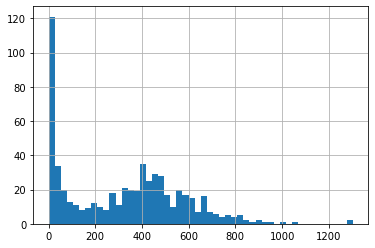

In [132]:
df_readsvssnps['SNP_num'].hist(bins=50)

In [9]:
df_readsvssnps['adj_snp_num'] = df_readsvssnps['SNP_num']/(df_readsvssnps['read_num']/1e8)

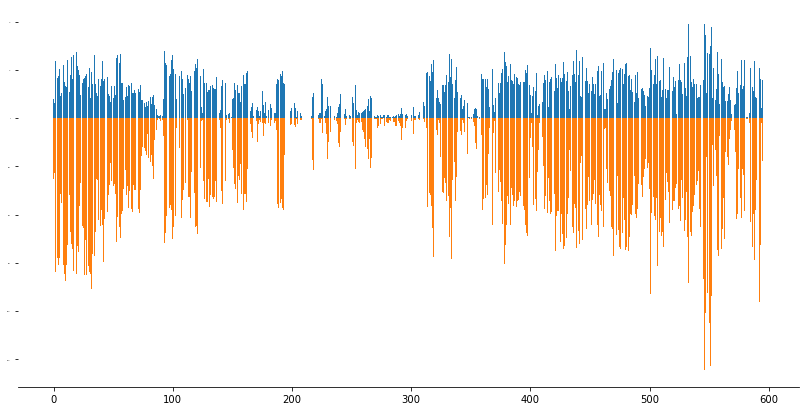

In [10]:
f,ax = plt.subplots(1,1, figsize = (14,7))
ax.bar(x = df_readsvssnps.index, height = df_readsvssnps['adj_snp_num'])
ax.bar(x = df_readsvssnps.index, height = df_readsvssnps['SNP_num'].apply(lambda x: x*(-1)))
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', labelsize=0)
plt.show()

<AxesSubplot:xlabel='SNP_num', ylabel='read_num'>

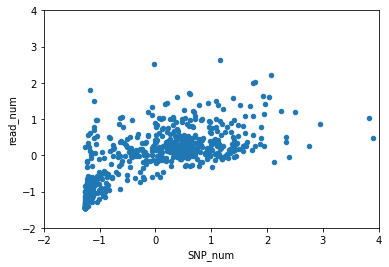

In [32]:
df_temp1 = (df_readsvssnps['SNP_num']-df_readsvssnps['SNP_num'].mean())/df_readsvssnps['SNP_num'].std()
df_temp2 = (df_readsvssnps['read_num']-df_readsvssnps['read_num'].mean())/df_readsvssnps['read_num'].std()
pd.concat((df_temp1, df_temp2),axis=1).plot(kind='scatter', x = 'SNP_num', y='read_num', xlim=(-2,4), ylim=(-2,4))

In [76]:
corr_list = []
start = []
end = []
for i in np.arange(0, 7, 0.5):
    r = df_readsvssnps.loc[(df_readsvssnps['read_num']>i*1e8)&(df_readsvssnps['read_num']<(i+0.5)*1e8)].\
    iloc[:, [0,3]].corr('pearson').iloc[0,1]
    corr_list.append(r)
    start.append(i)
    end.append(i+0.5)
pd.DataFrame({'r2':corr_list, 'start':start, 'end':end})

,r2,start,end
0,0.459416,0.0,0.5
1,0.136205,0.5,1.0
2,0.306842,1.0,1.5
3,0.203549,1.5,2.0
4,0.142215,2.0,2.5
5,-0.031949,2.5,3.0
6,-0.050315,3.0,3.5
7,-0.086703,3.5,4.0
8,0.183482,4.0,4.5
9,0.984440,4.5,5.0


/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


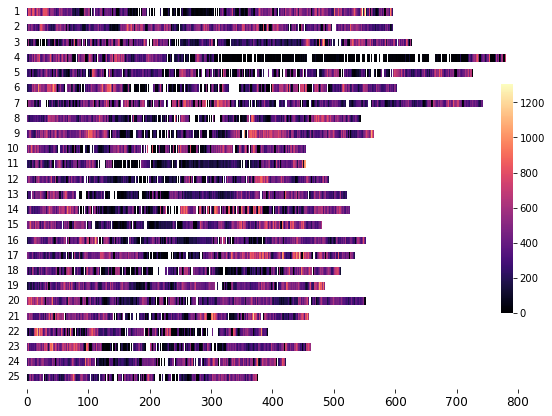

In [49]:
mask=np.zeros_like(df_snp_num)
mask[df_snp_num==0]=True
f,ax = plt.subplots(1,1,figsize=(10,7))
sns.heatmap(df_snp_num, cmap='magma',vmin=0,mask=mask, 
            cbar_kws={"shrink": 0.6,
                     'label':'',
                      'pad':-0.03})
ax.figure.axes[-1].set_yticklabels(ax.figure.axes[-1].get_yticklabels(),fontsize=10)
#ax.figure.axes[-1].set_ylabel('SNP counts per 100kb',size=15)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size=10)
#ax.set_yticklabels("")
ax.set_xticks(np.arange(0,810,100))
ax.set_xticklabels(labels = np.arange(0,810,100), size=12,rotation=0)
ax.set_ylabel('',size=20)
#ax.set_xlabel('Position(100kb)',size=10)
ax.tick_params(axis='y', left=False)
plt.show()

### MAF

In [30]:
df_maf = df_mlma_pruned_v5['Freq'].apply(lambda x : min(x, 1-x))

In [31]:
df_maf_all = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/MAF/chrs_maf.frq', 
                         delim_whitespace=True)


In [32]:
df_maf_all['MAF'].mean()

0.17682123606615624

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


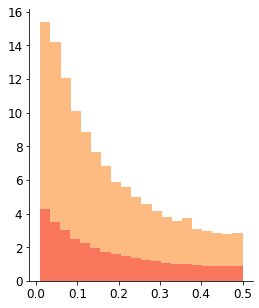

In [48]:
from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(1,1, figsize=(4,5))

ax.hist(df_maf_all['MAF'], bins=20, facecolor = '#febb81')
ax.hist(df_maf, bins=20, facecolor = '#f8765c')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels(np.arange(0, round(ax.patches[0].get_height()/1e5)+1, round(ax.patches[0].get_height()/1e6)), 
                   rotation=0, size=12)

ax.set_xticklabels(np.arange(0,0.6,0.1), size=12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_ylabel('', size=15)
ax.set_xlabel('', size=15)
plt.show()

### LD_decay

In [40]:
output_dir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/LD_decay/'
def func1(chr_num, output_dir):
    df = df_mlma_pruned_v5.loc[(df_mlma_pruned_v5['Chr']==chr_num)&(df_mlma_pruned_v5['MAF']>0.2)]
    step = round((df['bp'].max()-df['bp'].min())/1000)
    snp_list = []
    pos = df['bp'].min()
    while pos<=df['bp'].max():
        df_bin = df.loc[(df['bp']>=pos)&(df['bp']<=pos+step)].sort_values('bp')
        if df_bin.shape[0]>0:
            snp = df_bin.iloc[round(df_bin.shape[0]/2),3]
            snp_list.append(snp)
        pos+=step
        if pos>df['bp'].max():
            break
    if chr_num<=9: 
        filename = output_dir+'chr'+str(0)+str(chr_num)+'_snp_for_ld_decay.txt'
    else:
        filename = output_dir+'chr'+str(chr_num)+'_snp_for_ld_decay.txt'
    pd.Series(snp_list).\
    to_csv(filename, header=None, index=None)
for chr_num in range (1,26):
    func1(chr_num, output_dir)

KeyError: 'MAF'

In [37]:
input_dir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Gwas/data/LD_decay/'
def func2(chr_num, input_dir):
    if chr_num<=9:
        filename = 'chr0'+str(chr_num)+'_ld_decay.ld'
    else:
        filename = 'chr'+str(chr_num)+'_ld_decay.ld'
    df_ld = pd.read_csv(input_dir+filename, delim_whitespace=True)
    df_ld['MAF_diff'] = df_ld['MAF_A']-df_ld['MAF_B']
    df_ld['distance'] = (df_ld['BP_A']-df_ld['BP_B']).abs()
    df_ld = df_ld.loc[(df_ld['MAF_diff'].abs()<0.05)&(df_ld['distance'].abs()<5000000)]
    df_ld['range'] = df_ld['distance'].apply(lambda x: (x//100000)+1)
    df_summary = df_ld.groupby('range')['R2'].mean()
    df_summary = df_summary.reset_index()
    df_summary = df_summary.loc[df_summary['R2']>0.1]
    df_summary['Chr'] = chr_num
    return df_summary
df_summary_list = []
for chr_num in range(1,26,1):
    df_summary_list.append(func2(chr_num, input_dir))
    print(chr_num)
df_summary = pd.concat(df_summary_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [372]:
pal = sns.color_palette("deep")
pal.as_hex()
print(pal.as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


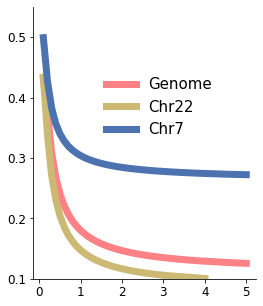

In [50]:
df_plot = df_summary.groupby('range')['R2'].mean().reset_index()
xdata=df_plot['range']
ydata=df_plot['R2']
xdata1 = df_summary.loc[df_summary['Chr']==22]['range']
ydata1 = df_summary.loc[df_summary['Chr']==22]['R2']
xdata2 = df_summary.loc[df_summary['Chr']==7]['range']
ydata2 = df_summary.loc[df_summary['Chr']==7]['R2']
def func(x, a,b,c):
    return a+b*(1/x)+c*(1/x**2)

popt, pcov = curve_fit(func, xdata, ydata)
popt1, pcov1 = curve_fit(func, xdata1, ydata1)
popt2, pcov2 = curve_fit(func, xdata2, ydata2)
## assess the fittness using R_squared
residuals = ydata-func(xdata, *popt)

ss_res = np.sum(residuals**2)

ss_tot = np.sum((ydata-np.mean(ydata))**2)

R_squared = 1-(ss_res/ss_tot)

f, ax = plt.subplots(1,1, figsize=(4,5))
ax.plot(xdata, func(xdata,*popt),color='#fe8186', label = "Genome", linewidth=7)
ax.plot(xdata1, func(xdata1,*popt1),color='#ccb974', label = 'Chr22',linewidth=7)
ax.plot(xdata2, func(xdata2,*popt2),color='#4c72b0',label = 'Chr7',linewidth=7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(np.arange(0,xdata.max()+10,10))
ax.set_xticklabels(np.arange(0,6,1), fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(frameon=False, fontsize=15, loc=[0.3,0.5])
ax.set_ylim(0.1,0.55)
ax.set_yticks(np.arange(0.1, 0.6, 0.1))
plt.show()

In [325]:
rapid= []
for chr_num in range(1,26,1):
    df_plot = df_summary.loc[df_summary['Chr']==chr_num]
    rapid.append(df_plot.loc[df_plot['range']==10].iloc[0, 1])
pd.Series(rapid).sort_values()

22    0.132411
21    0.147269
8     0.148260
24    0.148532
0     0.150129
3     0.159125
5     0.160197
13    0.161049
16    0.169105
20    0.171543
19    0.178313
1     0.182390
9     0.187549
23    0.188223
4     0.189267
12    0.190422
17    0.195282
7     0.199904
2     0.200243
10    0.207741
14    0.211096
18    0.221502
15    0.226964
11    0.264188
6     0.306574
dtype: float64

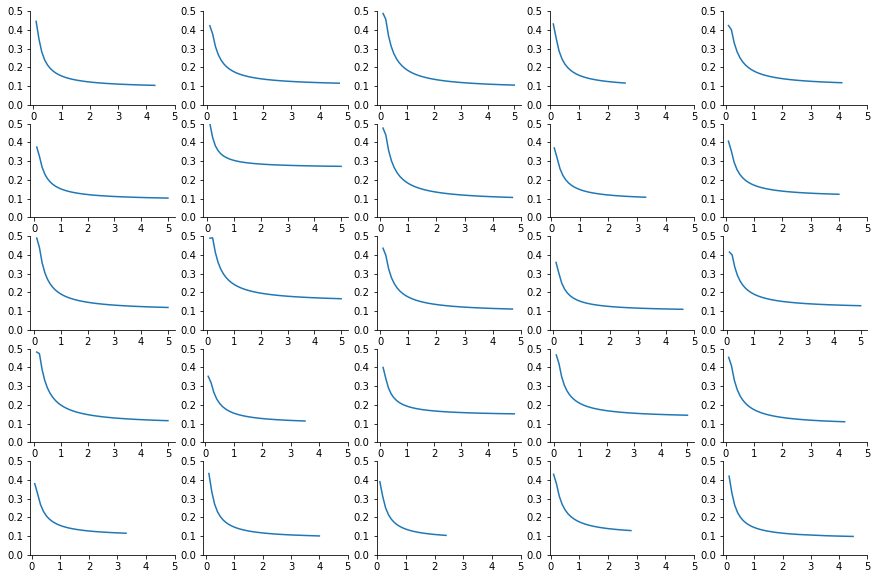

In [323]:
f, ax = plt.subplots(5,5, figsize=(15,10))
for chr_num in range(1,26,1):
    df_plot = df_summary.loc[df_summary['Chr']==chr_num]
    xdata=df_plot['range']
    ydata=df_plot['R2']
    def func(x, a,b,c):
        return a+b*(1/x)+c*(1/x**2)

    popt, pcov = curve_fit(func, xdata, ydata)

    ## assess the fittness using R_squared
    residuals = ydata-func(xdata, *popt)

    ss_res = np.sum(residuals**2)

    ss_tot = np.sum((ydata-np.mean(ydata))**2)

    R_squared = 1-(ss_res/ss_tot)

    
    ax[(chr_num-1)//5][(chr_num-1)%5].plot(xdata, func(xdata,*popt), label=chr_num)
    #ax.plot(xdata, ydata, 'yo', label='observed')
    ax[(chr_num-1)//5][(chr_num-1)%5].spines['right'].set_visible(False)
    ax[(chr_num-1)//5][(chr_num-1)%5].spines['top'].set_visible(False)
    ax[(chr_num-1)//5][(chr_num-1)%5].set_xticks(np.arange(0,60,10))
    ax[(chr_num-1)//5][(chr_num-1)%5].set_xticklabels(np.arange(0,6,1), fontsize=10)
    ax[(chr_num-1)//5][(chr_num-1)%5].tick_params(axis='y', labelsize=10)
    ax[(chr_num-1)//5][(chr_num-1)%5].legend("", frameon=False)
    ax[(chr_num-1)//5][(chr_num-1)%5].set_ylim(0.1,0.5)
    ax[(chr_num-1)//5][(chr_num-1)%5].set_yticks(np.arange(0, 0.6, 0.1))
plt.show()